# Import & function

In [1]:
from PIL import Image, ImageDraw, ImageOps
import cv2 

import os
from os import listdir
from os.path import isfile, join

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Construct Gaussian mask

In [2]:
display_resolution = 1920/1080 # stim presentation display resolution
screenshot_resolution = 1517/854 # measured by snipaste (grid on)
print(display_resolution), print(screenshot_resolution)
print(display_resolution - screenshot_resolution) # aspect ratio error 0.1%

grating_diameter_screenshot = 440 # grating radius pixel in screenshot
print(grating_diameter_screenshot / 854 * 1080), print(grating_diameter_screenshot / 1517 * 1920)
grating_diameter = math.ceil(np.max([grating_diameter_screenshot / 854 * 1080, 
                                grating_diameter_screenshot / 1517 * 1920])) # estimations are similar
grating_diameter # this should also be the radius of natural image cropped to squares

1.7777777777777777
1.7763466042154568
0.0014311735623209199
556.440281030445
556.8885959129861


557

In [3]:
'''
https://mworks.tenderapp.com/discussions/questions/1296
https://mworks.tenderapp.com/discussions/problems/271-gaussian-mask-issue
https://mworks.tenderapp.com/discussions/questions/736#comment_43095821
https://mworks.github.io/documentation/0.8/components/drifting_grating_stimulus.html
https://mworks.tenderapp.com/search?utf8=%E2%9C%93&q=mask+std_dev+&t=d&recommend=1

Gaussian mask is computed on a 2x2 square, centered at the origin
dist is distance from the center
The mask is then stretched to cover a rectangle of x_size by y_size degrees. If the x and y sizes are equal, then the mask is scaled by size/2 in both directions, so std_dev has units of size/2 degrees

central region of the mask can have values greater than one (see https://mworks.tenderapp.com/discussions/problems/271-gaussian-mask-issue). However, the mask value is used as the output color's alpha, which is clamped to the range [0,1]. Hence, every pixel in the central region gets an alpha of 1.
'''

# replicate mwork gaussian mask. check if reasonable
# for grating we used, mean=0.1 & std=0.3

mask_mean = 0.225
mask_std = 0.3 # std_dev in mwork

u = np.linspace(-1, 1, grating_diameter, endpoint=True) # nstep = grating_diameter in terms of pixel number
[x, y] = np.meshgrid(u, u)
y = y[::-1] # ensure y axis points upwards

distance = np.sqrt(x**2 + y**2)
mask = np.exp(-1/2 * ((distance-mask_mean) / mask_std)**2) / (mask_std * np.sqrt(2*np.pi)) # default drifting grating has normalization term
mask_flat_peak = mask.copy()
mask_flat_peak[mask_flat_peak>1.0] = 1.0 # alpha value is capped at 1

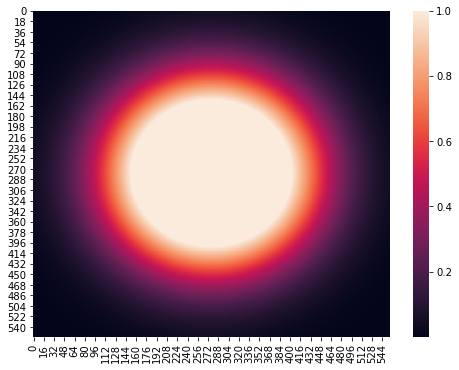

In [4]:
plt.figure(figsize=(8,6))
sns.heatmap(mask_flat_peak, annot=False, fmt=".1g", cbar=True)

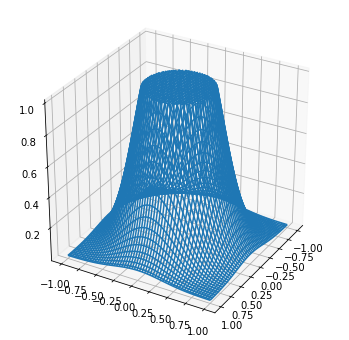

In [5]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x,y,mask_flat_peak, rstride=10, cstride=10)
ax.view_init(elev=30, azim=30)

# Grayscale & Gaussian mask as alpha
no need to cut into circle, just apply gaussian mask

In [6]:
def prep_img(input_path, input_img, chunk_height, chunk_width, save_path):

    if input_path[-1] != "/": input_path = input_path + "/"
    if save_path[-1] != "/": save_path = save_path + "/" # ensure input_path & save_path end with slash
    input_full = input_path + input_img
    
    im = Image.open(input_full).convert('L') # convert to grayscale
    img_width, img_height = im.size
    
    k = 0
    for i in range(0, img_height-chunk_height, chunk_height):
        for j in range(0, img_width-chunk_width, chunk_width):
            
            box = (j, i, j+chunk_width, i+chunk_height)
            chunk = im.crop(box) # cut into square piece
            chunk_arr =np.array(chunk)
            rgba = cv2.cvtColor(chunk_arr, cv2.COLOR_RGB2RGBA) # create img w alpha channel

            mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:])) * 255 
            mask_0_base[mask_0_base<0] = 0 # convert mask from 0-1 to 0-255, and force edge(outside of incircle)=0
            rgba[:, :, -1] = mask_0_base # assign mask to the last channel (alpha)

            img = Image.fromarray(rgba)
#             if i==0 and j==0: display(img)
            
            img.save(save_path + input_img[:-4] + "_" + str(k) + ".png")
            k = k+1
    

In [7]:
# input_path = 'Z:/All_Staff/home/lan/Data/stimulus_image/McGill/Shadows_high_reso/'
# save_path = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/'

# input_img = 'merry_mexico0141.TIF'
# chunk_height = grating_diameter
# chunk_width = grating_diameter

# prep_img(input_path, input_img, chunk_height, chunk_width, save_path)

# Batch pre-process

In [8]:
# rename image files in directory

input_path = 'Z:/All_Staff/home/lan/Data/stimulus_image/McGill/Shadows_high_reso/'
file_list = [f for f in listdir(input_path) if isfile(join(input_path, f))]

ifile = 0
for onefile in file_list:
    os.rename(input_path+onefile, input_path+str(ifile)+'.TIF')
    ifile += 1

['32.TIF',
 '34.TIF',
 '38.TIF',
 '23.TIF',
 '5.TIF',
 '22.TIF',
 '1.TIF',
 '18.TIF',
 '41.TIF',
 '48.TIF',
 '17.TIF',
 '33.TIF',
 '24.TIF',
 '9.TIF',
 '51.TIF',
 '14.TIF',
 '2.TIF',
 '46.TIF',
 '20.TIF',
 '4.TIF',
 '26.TIF',
 '36.TIF',
 '25.TIF',
 '52.TIF',
 '7.TIF',
 '39.TIF',
 '37.TIF',
 '28.TIF',
 '49.TIF',
 '0.TIF',
 '27.TIF',
 '30.TIF',
 '31.TIF',
 '8.TIF',
 '11.TIF',
 '12.TIF',
 '50.TIF',
 '35.TIF',
 '42.TIF',
 '43.TIF',
 '16.TIF',
 '3.TIF',
 '45.TIF',
 '47.TIF',
 '44.TIF',
 '54.TIF',
 '21.TIF',
 '13.TIF',
 '15.TIF',
 '19.TIF',
 '53.TIF',
 '6.TIF',
 '10.TIF',
 '40.TIF',
 '29.TIF']

In [14]:
# batch process them: grayscale & add gaussian mask

input_path = 'Z:/All_Staff/home/lan/Data/stimulus_image/McGill/Shadows_high_reso/'
save_path = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225'
file_list = [f for f in listdir(input_path) if isfile(join(input_path, f))]

for onefile in file_list:
    
    input_img = onefile
    chunk_height = grating_diameter
    chunk_width = grating_diameter
    prep_img(input_path, input_img, chunk_height, chunk_width, save_path)

# Calculate img stats
## ensure not blank
even if img blank, luminance distribution of the center is still not uniform, so not using uniform dist test

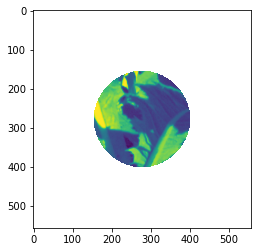

In [37]:
mask_step = mask_flat_peak.copy()
mask_step[mask_step<1] = np.nan

pic = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/12_10.png'
im = Image.open(pic)
im_arr =np.array(im)

np.testing.assert_array_equal(im_arr[:,:,0], im_arr[:,:,2]) # channel 0,1,2 (RGB) are equal, so their avg = any of them
im_center = im_arr[:,:,0] * mask_step # thus gray channel == red channel

plt.imshow(im_center); plt.colorbar;

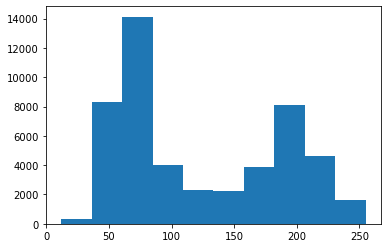

In [38]:
center_arr = im_center[~np.isnan(im_center)]
plt.hist(center_arr);

In [39]:
# criterion minmax: covers >30% of 0-255 full range
center_arr = im_center[~np.isnan(im_center)]
minmax = (np.mean(np.sort(center_arr)[::-1][:20]) - np.mean(np.sort(center_arr)[:20])) / 256
flag_minmax = minmax>0.3
flag_minmax

True

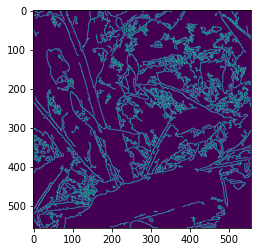

In [46]:
# criterion edge: can detect edge in img
pic = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/12_10.png'
image = cv2.imread(pic)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, threshold1=10, threshold2=100)
flag_edge = np.max(edges)>0
flag_edge
plt.imshow(edges)

# Misc

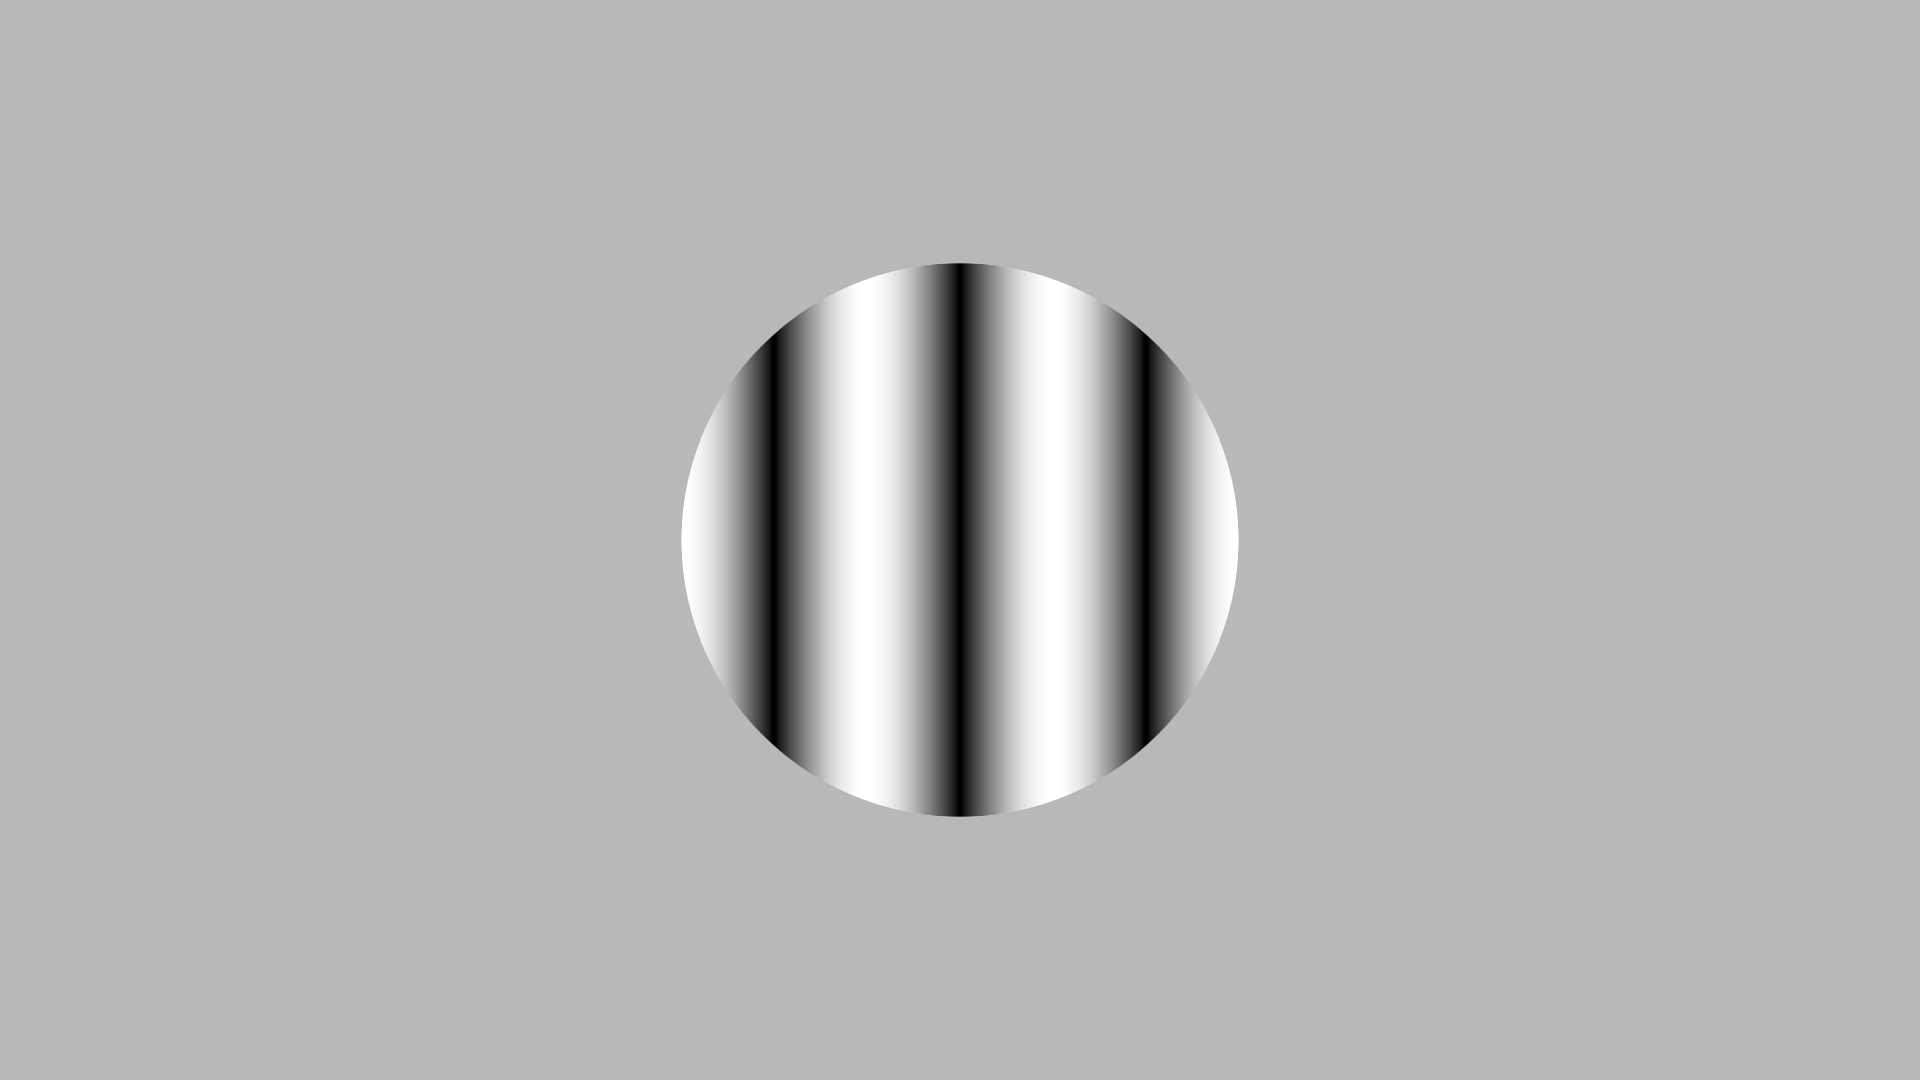

(184, 184, 184, 255)
0.7215686274509804


In [8]:
filename = 'C:\\Users\\lan\\Documents\\repos\\inter\\code\\mwork\\match_grating\\grating_no_mask.png'
img = Image.open(filename)
display(img)
color = img.getpixel((0,0))
print(color)
print(184/255) # take 0.5 instead